In [1]:

using CSV, DataFrames, Pkg

In [2]:
#Pkg.add(["MLJ","MultivariateStats","MLJMultivariateStatsInterface"])
import MultivariateStats
using MLJ 

In [3]:
#Pkg.add("PlotlyJS")
using PlotlyJS

In [4]:
import RDatasets
iris = RDatasets.dataset("datasets", "iris")

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [5]:
schema(iris)

┌─────────────┬───────────────┬─────────────────────────────────┐
│ names       │ scitypes      │ types                           │
├─────────────┼───────────────┼─────────────────────────────────┤
│ SepalLength │ Continuous    │ Float64                         │
│ SepalWidth  │ Continuous    │ Float64                         │
│ PetalLength │ Continuous    │ Float64                         │
│ PetalWidth  │ Continuous    │ Float64                         │
│ Species     │ Multiclass{3} │ CategoricalValue{String, UInt8} │
└─────────────┴───────────────┴─────────────────────────────────┘


We will start with PCA.

In [6]:
features = [:SepalWidth, :SepalLength, :PetalWidth, :PetalLength]

4-element Vector{Symbol}:
 :SepalWidth
 :SepalLength
 :PetalWidth
 :PetalLength

In [7]:

iris_pca = fit(PCA, Matrix(iris[!,features]))

UndefVarError: UndefVarError: `fit` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing StatsBase in the current active module Main
Hint: a global variable of this name may be made accessible by importing Distributions in the current active module Main
Hint: a global variable of this name also exists in MultivariateStats.
Hint: a global variable of this name may be made accessible by importing MLJModelInterface in the current active module Main
Hint: a global variable of this name may be made accessible by importing MLJBase in the current active module Main

Another approach would be the following

In [8]:
PCA_mlj = @load PCA pkg=MultivariateStats
mach = machine(PCA_mlj(maxoutdim=3), iris[!, features])
fit!(mach)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/christos/.julia/packages/MLJModels/ziReN/src/loading.jl:159


import MLJMultivariateStatsInterface ✔


┌ Info: Training machine(PCA(maxoutdim = 3, …), …).
└ @ MLJBase /Users/christos/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


trained Machine; caches model-specific representations of data
  model: PCA(maxoutdim = 3, …)
  args: 
    1:	Source @807 ⏎ Table{AbstractVector{Continuous}}


In [9]:
report(mach)

(indim = 4,
 outdim = 3,
 tprincipalvar = 4.549121954006417,
 tresidualvar = 0.023835092973449434,
 tvar = 4.572957046979867,
 mean = [3.0573333333333332, 5.843333333333334, 1.1993333333333336, 3.7580000000000005],
 principalvars = [4.228241706034865, 0.24267074792863286, 0.07820950004291946],
 loadings = [0.17380101531344927 -0.35968937171605764 0.16721151231597908; -0.7431080022653199 -0.32344628375163953 -0.16277024390683958; -0.7367389260713403 0.037183175305051205 0.15264700791988584; -1.7615451072542463 0.08540618715660012 0.02132015158334761],)

Now let's plot the first 2 PC.

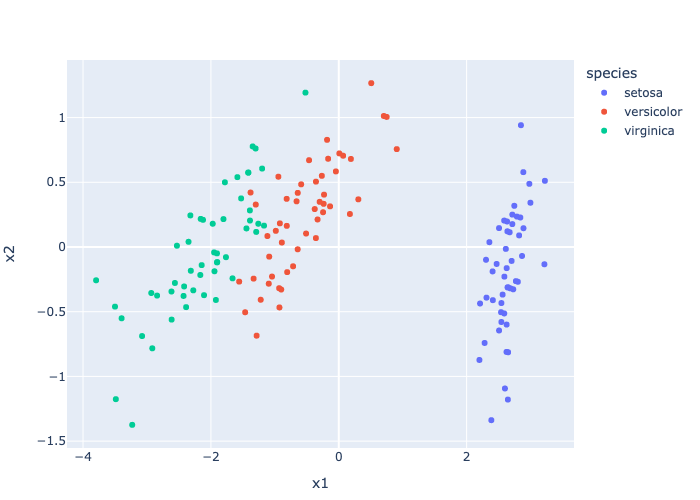

In [10]:
components = MLJ.transform(mach, iris[!, features])
components.species = iris.Species
plot(components, x=:x1, y=:x2, color=:species, mode="markers")

Now let's split the features from the response variable.

In [11]:
y, X = unpack(iris, ==(:Species); rng=2024);

Let's see our options.

In [12]:
models(matching(X,y))

54-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianLDA, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianQDA, package_

Will try first a decision tree classifier.

In [13]:
#Pkg.add("MLJDecisionTreeInterface")
Tree = @load DecisionTreeClassifier pkg=DecisionTree

import MLJDecisionTreeInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/christos/.julia/packages/MLJModels/ziReN/src/loading.jl:159


MLJDecisionTreeInterface.DecisionTreeClassifier

In [14]:
tree = Tree()

DecisionTreeClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random.TaskLocalRNG())

It can be useful to know what type of response variable the model expects.

In [15]:
target_scitype(tree)

AbstractVector{<:Finite} (alias for AbstractArray{<:Finite, 1})

In [16]:
subtypes(Finite)

2-element Vector{Any}:
 Multiclass
 OrderedFactor

In connection to the above we can check how our response variable will be interpreted.

In [17]:
scitype(y)

AbstractVector{Multiclass{3}} (alias for AbstractArray{Multiclass{3}, 1})

Now let's fit and evaluate our classifier.

In [18]:
evaluate(tree, X, y,
                resampling=CV(shuffle=true, nfolds=5,rng=123),
                measures=[log_loss, accuracy])

Evaluating over 5 folds: 100%[=========================] Time: 0:00:04


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 2.88        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.92        │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬─────────────────────────────────┬─────────┐
│   │ per_fold                        │ 1.96*SE │
├───┼─────────────────────────────────┼─────────┤
│ A │ [6.01, 3.6, 2.4, 2.4, 2.22e-16] │ 2.14    │
│ B │ [0.833, 0.9, 0.933, 0.933, 1.0] │ 0.0593  │
└───┴─────────────────────────────────┴─────────┘


Let's see now the process when when don't want to perform cross validation. We will set up a training and a test set.

In [18]:
mach = machine(tree, X, y)

untrained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = -1, …)
  args: 
    1:	Source @514 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @020 ⏎ AbstractVector{Multiclass{3}}


75% of the data will be used for training and the rest for validation.

In [19]:
train, test = partition(eachindex(y), 0.75)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  103, 104, 105, 106, 107, 108, 109, 110, 111, 112], [113, 114, 115, 116, 117, 118, 119, 120, 121, 122  …  141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

A common procedure in ML is to standardize our features. Let's do that for the numeric features of the `iris`dataset.

In [20]:
#Pkg.add("MLJModels")
using MLJModels


In [21]:
stand = Standardizer() 

Standardizer(
  features = Symbol[], 
  ignore = false, 
  ordered_factor = false, 
  count = false)

In [22]:
X_std = MLJ.transform(fit!(machine(stand,X)), X)

┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /Users/christos/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


Row,SepalLength,SepalWidth,PetalLength,PetalWidth
,Float64,Float64,Float64,Float64
1,-0.414621,-1.50811,-0.0328556,-0.261511
2,1.27607,0.0978893,0.760211,1.44399
3,1.63836,0.327318,1.27004,0.788031
4,0.309959,-0.590395,0.137087,0.132067
5,-0.293857,-1.27868,0.0804397,-0.130318
6,0.672249,0.0978893,0.986802,0.788031
7,-0.776911,1.0156,-1.2791,-1.31105
8,-1.50149,0.0978893,-1.2791,-1.31105
9,1.03454,0.0978893,0.533621,0.394453


In [23]:
evaluate(tree, X_std, y,
                resampling=CV(shuffle=true, nfolds=5,rng=123),
                measures=[log_loss, accuracy])

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 2.64        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.927       │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬─────────────────────────────────┬─────────┐
│   │ per_fold                        │ 1.96*SE │
├───┼─────────────────────────────────┼─────────┤
│ A │ [6.01, 3.6, 2.4, 1.2, 2.22e-16] │ 2.26    │
│ B │ [0.833, 0.9, 0.933, 0.967, 1.0] │ 0.0628  │
└───┴─────────────────────────────────┴─────────┘


Let's see some more models now.

In [24]:
crabs = RDatasets.dataset("MASS", "crabs")

Row,Sp,Sex,Index,FL,RW,CL,CW,BD
,Cat…,Cat…,Int32,Float64,Float64,Float64,Float64,Float64
1,B,M,1,8.1,6.7,16.1,19.0,7.0
2,B,M,2,8.8,7.7,18.1,20.8,7.4
3,B,M,3,9.2,7.8,19.0,22.4,7.7
4,B,M,4,9.6,7.9,20.1,23.1,8.2
5,B,M,5,9.8,8.0,20.3,23.0,8.2
6,B,M,6,10.8,9.0,23.0,26.5,9.8
7,B,M,7,11.1,9.9,23.8,27.1,9.8
8,B,M,8,11.6,9.1,24.5,28.4,10.4
9,B,M,9,11.8,9.6,24.2,27.8,9.7


In [25]:
levels(crabs.Sp)

2-element Vector{String}:
 "B"
 "O"

In [26]:
y_crabs, X_crabs = unpack(crabs, ==(:Sp); rng=2024);

In [27]:
scitype(y_crabs)

AbstractVector{Multiclass{2}} (alias for AbstractArray{Multiclass{2}, 1})

In [28]:
X_crabs

Row,Sex,Index,FL,RW,CL,CW,BD
,Cat…,Int32,Float64,Float64,Float64,Float64,Float64
1,F,34,19.1,16.0,37.8,42.3,16.8
2,M,42,20.6,14.4,42.8,46.5,19.6
3,M,26,17.1,12.6,35.0,38.9,15.7
4,F,22,17.5,14.4,34.5,39.0,16.0
5,F,20,12.6,12.2,26.1,31.6,11.2
6,F,49,22.5,17.2,43.0,48.7,19.8
7,M,28,15.7,12.6,35.8,40.3,14.5
8,M,4,9.6,7.9,20.1,23.1,8.2
9,F,37,15.2,14.3,33.9,38.5,14.7


In [29]:
evaluate(tree, select(X_crabs,names(X_crabs,Float64)), y_crabs,
                resampling=CV(shuffle=true, nfolds=5),
                measures=[log_loss, accuracy])

Evaluating over 5 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 3.42        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.905       │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬──────────────────────────────────┬─────────┐
│   │ per_fold                         │ 1.96*SE │
├───┼──────────────────────────────────┼─────────┤
│ A │ [1.8, 2.7, 2.7, 3.6, 6.31]       │ 1.7     │
│ B │ [0.95, 0.925, 0.925, 0.9, 0.825] │ 0.0471  │
└───┴──────────────────────────────────┴─────────┘


In [35]:
models(matching(X_crabs,y_crabs))

6-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = CatBoostClassifier, package_name = CatBoost, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = EvoTreeClassifier, package_name = EvoTrees, ... )
 (name = RandomForestClassifier, package_name = BetaML, ... )

In [31]:
#Pkg.add("BetaML")
RF = @load RandomForestClassifier pkg=BetaML

import BetaML

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/christos/.julia/packages/MLJModels/ziReN/src/loading.jl:159


 ✔


BetaML.Bmlj.RandomForestClassifier

In [32]:
rf = RF()

RandomForestClassifier(
  n_trees = 30, 
  max_depth = 0, 
  min_gain = 0.0, 
  min_records = 2, 
  max_features = 0, 
  splitting_criterion = BetaML.Utils.gini, 
  β = 0.0, 
  rng = Random.TaskLocalRNG())

In [33]:
evaluate(rf, select(X_crabs,names(X_crabs,Float64)), y_crabs,
                resampling=CV(shuffle=true, nfolds=5),
                measures=[log_loss, accuracy])

Evaluating over 5 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────┬──────────────┬─────────────┐
│   │ measure              │ operation    │ measurement │
├───┼──────────────────────┼──────────────┼─────────────┤
│ A │ LogLoss(             │ predict      │ 1.23        │
│   │   tol = 2.22045e-16) │              │             │
│ B │ Accuracy()           │ predict_mode │ 0.85        │
└───┴──────────────────────┴──────────────┴─────────────┘
┌───┬─────────────────────────────────┬─────────┐
│   │ per_fold                        │ 1.96*SE │
├───┼─────────────────────────────────┼─────────┤
│ A │ [2.96, 1.16, 0.42, 0.233, 1.37] │ 1.06    │
│ B │ [0.85, 0.85, 0.85, 0.9, 0.8]    │ 0.0346  │
└───┴─────────────────────────────────┴─────────┘


## Special Exercise

We will use the titanic dataset. Using the available features make predictions whether a passenger survived. The data are taken from `Kaggle` and they are already split in a training and a test dataset.